# Exercício 2

Queremos construir uma caixa com uma base quadrada e temos apenas 10 m2 de materiais para usar na construção da caixa. Partindo do princípio de que todo o material disponível é utilizado no processo de construção da caixa, determinar o volume máximo que a caixa pode ter.

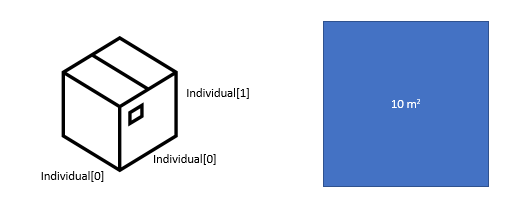

## Instalar pacote DEAP

In [1]:
!pip install deap

# Importar bibliotecas necessárias

In [2]:
import matplotlib.pyplot as plt
from deap import base, creator, tools
import pandas as pd
import operator
import random
import numpy
import math

# Função objetivo

   - Função objetivo com objetivo de maximizar a area

In [3]:
def objective_function(individual):
    volume = (individual[0]**2) * (individual[1])
    return volume,

# Restrição do problema


   - Verificar partícula - restrições impostas as partículas
       - Há uma restrição do tamanho quanto a área do material utilizado  <= 10m2

In [41]:
def feasible(individual):
  if (2*(individual[0]**2) + 4*(individual[0]*individual[1])) > 10:
    #print("Rest1")
    return False
  if (individual[0] < 0) or (individual[1] < 0):
    #print("Rest2")
    return False
  return True

## Criando a função de Minimização e a estrutura da partícula

In [42]:
#  função objetivo: nome, tipo(f.o.), o peso deve ser 1.0 para esse caso (função de maximização)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, smin=None, smax=None, best=None) # smin e smax são limites de speed. best é a melhor até o momento.

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


## Definindo uma função para gerar a partícula

In [43]:
# Função que cria uma partícula inicializando os atributos aleatoriamente.
# size é o número de variáveis de decisão, pmin e pmax são os limites das variáveis, smin e smax são os limites de velocidade
def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size)) 
    part.speed = [random.uniform(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

## Definindo a função para atualização da partícula 

In [44]:
# Esta função calcula a velocidade, os limites de veloicidade e a nova posição da partícula
# phi1 = fator cognitivo e phi2 = fator social
def updateParticle(part, best, phi1, phi2):
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part)) # indo em direção ao melhor conhecido pela partícula
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part)) # indo em direção ao melhor da vizinhaça
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
    part[:] = list(map(operator.add, part, part.speed))

## Criando o toolbox

In [45]:
toolbox = base.Toolbox()

# Função para gerar a partícula com valores 
toolbox.register("particle", generate, size=2, pmin=0, pmax=2, smin=-3, smax=3)

# Adicionando a função para gerar a população
toolbox.register("population", tools.initRepeat, list, toolbox.particle)

# Adicionando a função para atualizar a população
toolbox.register("update", updateParticle, phi1=2.0, phi2=2.0)

# Adicionando as funções para avaliar a população
toolbox.register("evaluate", objective_function)
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, -1000000))

## Definindo parêmetros para o PSO

   - **initial_population:** Número de inidivíduos da população inicial
   - **num_gen:** Número de iterações
   - **best:** Melhor partícula

In [46]:
initial_population = 100    
num_ite = 1000
best = None

### Criando a população inicial

In [47]:
# inicializando a população
pop = toolbox.population(n=initial_population)

### Estatísticas de avaliação (a cada geração)

   - Função objetivo
   - Média
   - Desvio padrão
   - Mínimo
   - Máximo

In [48]:
# estatísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

### Definindo um log para avaliar as partículas ao longo das iterações

In [49]:
logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields

## Otimização

In [50]:
# Roda a otimização
for iteration in range(num_ite):
    for part in pop:
        part.fitness.values = toolbox.evaluate(part)
        # atualiza melhor da partícula
        if not part.best or part.best.fitness < part.fitness:
            part.best = creator.Particle(part)
            part.best.fitness.values = part.fitness.values
        # atualiza melhor global
        if not best or best.fitness < part.fitness:
            best = creator.Particle(part)
            best.fitness.values = part.fitness.values
    for part in pop:
        toolbox.update(part, best)

    # Salva todos os fitnesses em uma lista e imprime o status
    logbook.record(gen=iteration, evals=len(pop), **stats.compile(pop))
    print(logbook.stream)

gen	evals	avg    	std   	min   	max    
0  	100  	-330000	470213	-1e+06	2.01837
1  	100  	-880000	324962	-1e+06	1.8335 
2  	100  	-660000	473709	-1e+06	2.0384 
3  	100  	-830000	375633	-1e+06	1.92001
4  	100  	-800000	400000	-1e+06	2.10491
5  	100  	-760000	427084	-1e+06	1.92765
6  	100  	-790000	407308	-1e+06	1.87527
7  	100  	-810000	392301	-1e+06	1.09196
8  	100  	-830000	375633	-1e+06	1.89081
9  	100  	-790000	407308	-1e+06	1.52713
10 	100  	-810000	392301	-1e+06	1.587  
11 	100  	-810000	392301	-1e+06	1.98104
12 	100  	-780000	414247	-1e+06	1.91701
13 	100  	-810000	392301	-1e+06	2.02123
14 	100  	-800000	400000	-1e+06	1.78769
15 	100  	-740000	438635	-1e+06	1.79113
16 	100  	-760000	427083	-1e+06	2.0341 
17 	100  	-820000	384188	-1e+06	1.91856
18 	100  	-810000	392301	-1e+06	1.78552
19 	100  	-800000	400000	-1e+06	0.921345
20 	100  	-840000	366606	-1e+06	2.05496 
21 	100  	-810000	392301	-1e+06	1.37799 
22 	100  	-850000	357072	-1e+06	1.56953 
23 	100  	-750000	433013	-1e+06	1.89

## Melhor indivíduo

In [51]:
print('Base: ', best[0])
print('Altura: ', best[1])


Base:  1.2801669071387476
Altura:  1.3117850670294775


## Avaliação do melhor indivíduo

In [52]:
print('Area: ', (2*(best[0]**2) + 4*(best[0]*best[1])))
print('Volume: ', objective_function(best)[0])

Area:  9.994869948626057
Volume:  2.1497891928728006
